In [1]:
import os
print(os.getcwd())

work_directory_R = os.getcwd() + "/Results_ROC"
work_directory_C = os.getcwd() + "/Results_CM"
work_directory_P = os.getcwd() + "/ResultsPredicted"
Results_File = os.getcwd() + "/Metrics_Result.txt"

import shutil

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(work_directory_R)
    shutil.rmtree(work_directory_C)
    shutil.rmtree(work_directory_P)
    os.remove(Results_File)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
    
import gc as g

# %reset
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

import tensorflow as tf,keras
from keras import backend as K, optimizers, regularizers
# K.clear_session()

import pickle, sys,os,cv2, numpy as np, pandas as pd, scipy, seaborn as sns, json, joblib, sklearn as sk
from random import shuffle
from keras.models import Sequential, Model, load_model, model_from_json
# from keras.layers import Dense, Permute, Dropout, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, ZeroPadding2D, merge
from keras.layers import Dense, Dropout, Permute, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, ZeroPadding2D, merge
from keras.layers import SeparableConv2D, DepthwiseConv2D, BatchNormalization, SpatialDropout2D
from keras.layers.merge import concatenate
from keras import utils as np_utils
from keras.regularizers import l2, l1_l2
from keras.constraints import max_norm

from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator,array_to_img
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.cm as cm

get_ipython().magic('matplotlib inline')
%matplotlib inline

from keras import layers
# from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, GroupKFold, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler


# from keras.utils.training_utils import multi_gpu_model
# from keras.utils import multi_gpu_model
# from keras import layers
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import joblib


from tqdm import tqdm
from functools import partial
from sklearn import metrics
from collections import Counter
from itertools import cycle
from six.moves import cPickle as pickle
from scipy import interp
from skimage.feature import local_binary_pattern,hog
from skimage import data, exposure

import itertools
from time import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import radiomics
# import SimpleITK as sitk
import pkgutil
import xlsxwriter
from PIL import Image
from natsort import natsorted

print('Libraries Loaded')

print()
print(f"Python Version: {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tf.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Scikit-Learn Version: {sk.__version__}")

tf.__version__
tf.test.is_built_with_cuda()

# GPU Check 1
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22
Error: D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22/Results_ROC - The system cannot find the path specified.


Using TensorFlow backend.


Libraries Loaded

Python Version: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 1.15.0
Keras Version: 2.2.4
Numpy Version: 1.19.2
Pandas Version: 1.1.5
OpenCV Version: 4.6.0
Scikit-Learn Version: 0.24.2


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11222091171223185746,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15125499085
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18224766157615657739
 physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5"]

In [2]:
# # print(device_lib.list_local_devices())# 사용 가능한 모든 디바이스를 출력: RTX 3090 정보 출력


# # GPU Check 1  
# gpus = tf.config.experimental.list_physical_devices('CPU')
# for gpu in gpus:
#     print("\nName:", gpu.name, "  Type:", gpu.device_type)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     print("Name:", gpu.name, "  Type:", gpu.device_type)

# # GPU Check 2
# tf.config.list_physical_devices('GPU')
# #tf.test.is_gpu_available('GPU') 위의 함수로 바뀐다고 함 (2.4.0)
# print("\n",tf.sysconfig.get_build_info())

# # GPU Check 3
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # # GPU Check 4
# # tf.__version__
# # tf.test.is_built_with_cuda()


In [3]:
def Mode(Organ, work_directory_Pickles, option_Mode):

    if option_Mode==1:
        Mode = "Train"
        data_file1 = work_directory_Pickles + '/Classify_C_' + str(Mode) + '_' + str(Organ) + '.pickle'
        data_file2 = ""
        
    elif option_Mode==2:
        Mode = "Test"
        data_file1 = work_directory_Pickles + '/Classify_C_' + str(Mode) + '_' + str(Organ) + '.pickle'
        data_file2 = ""
        
    elif option_Mode==3:
        Mode = "Train"
        data_file1 = work_directory_Pickles + '/Classify_C_' + str(Mode) + '_' + str(Organ) + '.pickle'

        Mode = "Test"
        data_file2 = work_directory_Pickles + '/Classify_C_' + str(Mode) + '_' + str(Organ) + '.pickle'
  
    return data_file1, data_file2 



def load_pickle(data_file,q):
    print('\nTring to load pickle from %s' % data_file)
    with open(data_file, 'rb') as file:
        datasets = pickle.load(file)
        dataset = datasets['dataset']

    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    
    print('\nPickle Loaded Successfully!')
    
    del dataset

    if q==1:
        print('\nX_train shape:', X_train.shape)
        print('Y_train shape:', Y_train.shape)
    
    return X_train,Y_train



def load_pickle__(data_file,q):
    print('\nTring to load pickle from %s' % data_file)
    with open(data_file, 'rb') as file:
        datasets = pickle.load(file)
        dataset = datasets['dataset']

    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    Y_train_ = dataset['Y_train_']
    
    print('\nPickle Loaded Successfully!')
    
    del dataset

    if q==1:
        print('\nX_train shape:', X_train.shape)
        print('Y_train shape:', Y_train.shape)
        print('Y_train shape:', Y_train_.shape)
    
    return X_train,Y_train,Y_train_



def save_pickle(x_train,y_train, data_file):
    print('\nTrying to save pickle to %s' % data_file)
    
    X_train = x_train
    Y_train = y_train
    del x_train,y_train
    
    # creating dictionary to store trian and test data
    datasets = {'dataset' : {'X_train': X_train,'Y_train': Y_train}}

    with open(data_file, 'wb') as file:
        pickle.dump(datasets, file, protocol=pickle.HIGHEST_PROTOCOL)
        del datasets # to free up memory.
        
    print('\nPickle Saved Successfully!')


def save_pickle__(x_train,y_train,y_train_, data_file):
    print('\nTrying to save pickle to %s' % data_file)
    
    X_train = x_train
    Y_train = y_train
    Y_train_ = y_train_
    del x_train,y_train,y_train_
    
    # creating dictionary to store trian and test data
    datasets = {'dataset' : {'X_train': X_train,'Y_train': Y_train,'Y_train_': Y_train_}}

    with open(data_file, 'wb') as file:
        pickle.dump(datasets, file, protocol=pickle.HIGHEST_PROTOCOL)
        del datasets # to free up memory.
        
    print('\nPickle Saved Successfully!')


def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)    

In [4]:
K.clear_session()
import gc
gc.collect()

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95,allow_growth = True)
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False,gpu_options=gpu_options))
# K.set_session(sess)


# memory_limit_ = 10288

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit_)])
#     except RuntimeError as e:
#         print(e)

0

In [5]:
option_Mode = 1
# option_Mode = 2
    
option_Model_C = 5

print("\n\n DataSet-MONUSAC \n")
print('\n\nSelect Organ')
option_Org = int(input("\n 1-Breast \n 2-Kidney \n 3-Lung \n 4-Prostate \n 5-All \n"))
while option_Org  not in (1,2,3,4,5):
    option_Org = int(input("\n 1-Breast \n 2-Kidney \n 3-Lung \n 4-Prostate \n 5-All \n"))

if option_Org==1:
    # if option_D0==1:
    Name_T = "E-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Breast_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Breast_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_E, Nuceli_Label_E = load_pickle(data_file,1)
    Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_ = load_pickle__(data_file_,1)

    Name_T = "L-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Breast_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Breast_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_L, Nuceli_Label_L = load_pickle(data_file,1)
    Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_ = load_pickle__(data_file_,1)

    Name_T = "M-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Breast_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Breast_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_M, Nuceli_Label_M = load_pickle(data_file,1)
    Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_ = load_pickle__(data_file_,1)

    Name_T = "N-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Breast_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Breast_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_N, Nuceli_Label_N = load_pickle(data_file,1)
    Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_ = load_pickle__(data_file_,1)
    print('\n\n\nLoad Complete')
    
    

elif option_Org==2:
    # if option_D0==1:
    Name_T = "E-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Kidney_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Kidney_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_E, Nuceli_Label_E = load_pickle(data_file,1)
    Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_ = load_pickle__(data_file_,1)

    Name_T = "L-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Kidney_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Kidney_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_L, Nuceli_Label_L = load_pickle(data_file,1)
    Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_ = load_pickle__(data_file_,1)

    Name_T = "M-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Kidney_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Kidney_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_M, Nuceli_Label_M = load_pickle(data_file,1)
    Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_ = load_pickle__(data_file_,1)

    Name_T = "N-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Kidney_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Kidney_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_N, Nuceli_Label_N = load_pickle(data_file,1)
    Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_ = load_pickle__(data_file_,1)
    print('\n\n\nLoad Complete')
    
    

elif option_Org==3:
    # if option_D0==1:
    Name_T = "E-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Lung_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Lung_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_E, Nuceli_Label_E = load_pickle(data_file,1)
    Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_ = load_pickle__(data_file_,1)

    Name_T = "L-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Lung_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Lung_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_L, Nuceli_Label_L = load_pickle(data_file,1)
    Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_ = load_pickle__(data_file_,1)

    Name_T = "M-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Lung_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Lung_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_M, Nuceli_Label_M = load_pickle(data_file,1)
    Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_ = load_pickle__(data_file_,1)

    Name_T = "N-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Lung_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Lung_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_N, Nuceli_Label_N = load_pickle(data_file,1)
    Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_ = load_pickle__(data_file_,1)
    print('\n\n\nLoad Complete')
    
    

elif option_Org==4:
    # if option_D0==1:
    Name_T = "E-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Prostate_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Prostate_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_E, Nuceli_Label_E = load_pickle(data_file,1)
    Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_ = load_pickle__(data_file_,1)

    Name_T = "L-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Prostate_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Prostate_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_L, Nuceli_Label_L = load_pickle(data_file,1)
    Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_ = load_pickle__(data_file_,1)

    Name_T = "M-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Prostate_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Prostate_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_M, Nuceli_Label_M = load_pickle(data_file,1)
    Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_ = load_pickle__(data_file_,1)

    Name_T = "N-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_Prostate_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_Prostate_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_N, Nuceli_Label_N = load_pickle(data_file,1)
    Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_ = load_pickle__(data_file_,1)
    print('\n\n\nLoad Complete')
    
    

elif option_Org==5:
    # if option_D0==1:
    Name_T = "E-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_All_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_All_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_E, Nuceli_Label_E = load_pickle(data_file,1)
    Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_ = load_pickle__(data_file_,1)

    Name_T = "L-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_All_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_All_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_L, Nuceli_Label_L = load_pickle(data_file,1)
    Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_ = load_pickle__(data_file_,1)

    Name_T = "M-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_All_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_All_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_M, Nuceli_Label_M = load_pickle(data_file,1)
    Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_ = load_pickle__(data_file_,1)

    Name_T = "N-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    data_file = 'January/PICKLESNEW/Classify_D_All_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_D_All_I_' + str(Name_T) + '_' + str(samples_Select) + '.pickle'   
    Nuceli_Output_N, Nuceli_Label_N = load_pickle(data_file,1)
    Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_ = load_pickle__(data_file_,1)
    print('\n\n\nLoad Complete')
    
    

from sklearn.utils import shuffle
Nuceli_Output_E , Nuceli_Output_E_ , Nuceli_Label_E_, Nuceli_Label_Type_E_ = shuffle(Nuceli_Output_E, Nuceli_Output_E_, Nuceli_Label_E_, Nuceli_Label_Type_E_, random_state=0)
Nuceli_Output_L , Nuceli_Output_L_ , Nuceli_Label_L_, Nuceli_Label_Type_L_ = shuffle(Nuceli_Output_L, Nuceli_Output_L_, Nuceli_Label_L_, Nuceli_Label_Type_L_, random_state=0)
Nuceli_Output_M , Nuceli_Output_M_ , Nuceli_Label_M_, Nuceli_Label_Type_M_ = shuffle(Nuceli_Output_M, Nuceli_Output_M_, Nuceli_Label_M_, Nuceli_Label_Type_M_, random_state=0)
Nuceli_Output_N , Nuceli_Output_N_ , Nuceli_Label_N_, Nuceli_Label_Type_N_ = shuffle(Nuceli_Output_N, Nuceli_Output_N_, Nuceli_Label_N_, Nuceli_Label_Type_N_, random_state=0)






 DataSet-MONUSAC 



Select Organ

 1-Breast 
 2-Kidney 
 3-Lung 
 4-Prostate 
 5-All 
1

Tring to load pickle from January/PICKLESNEW/Classify_D_Breast_E-GLCM GLDM GLRLM GLSZM_70.pickle

Pickle Loaded Successfully!

X_train shape: (540, 70)
Y_train shape: (540,)

Tring to load pickle from January/PICKLESNEW/Classify_D_Breast_I_E-GLCM GLDM GLRLM GLSZM_70.pickle

Pickle Loaded Successfully!

X_train shape: (540, 128, 128, 3)
Y_train shape: (540, 128, 128)
Y_train shape: (540,)

Tring to load pickle from January/PICKLESNEW/Classify_D_Breast_L-GLCM GLDM GLRLM GLSZM_70.pickle

Pickle Loaded Successfully!

X_train shape: (946, 70)
Y_train shape: (946,)

Tring to load pickle from January/PICKLESNEW/Classify_D_Breast_I_L-GLCM GLDM GLRLM GLSZM_70.pickle

Pickle Loaded Successfully!

X_train shape: (946, 128, 128, 3)
Y_train shape: (946, 128, 128)
Y_train shape: (946,)

Tring to load pickle from January/PICKLESNEW/Classify_D_Breast_M-GLCM GLDM GLRLM GLSZM_70.pickle

Pickle Loaded Successfully

In [6]:
if option_Model_C==1:
    print('\n\nX_train shape:', Nuceli_Output_E_.shape)
    print('Y_train shape:', Nuceli_Label_E_.shape)     

elif option_Model_C==2:
    print('\nX_train shape:', Nuceli_Output_L_.shape)
    print('Y_train shape:', Nuceli_Label_L_.shape)     

elif option_Model_C==3:
    print('\nX_train shape:', Nuceli_Output_M_.shape)
    print('Y_train shape:', Nuceli_Label_M_.shape)     

elif option_Model_C==4:
    print('\nX_train shape:', Nuceli_Output_N_.shape)
    print('Y_train shape:', Nuceli_Label_N_.shape)     

else:
    print('\n\nX_train shape:', Nuceli_Output_E_.shape)
    print('Y_train shape:', Nuceli_Label_E_.shape)     

    print('\nX_train shape:', Nuceli_Output_L_.shape)
    print('Y_train shape:', Nuceli_Label_L_.shape)     

    print('\nX_train shape:', Nuceli_Output_M_.shape)
    print('Y_train shape:', Nuceli_Label_M_.shape)     

    print('\nX_train shape:', Nuceli_Output_N_.shape)
    print('Y_train shape:', Nuceli_Label_N_.shape)     




X_train shape: (540, 128, 128, 3)
Y_train shape: (540, 128, 128)

X_train shape: (946, 128, 128, 3)
Y_train shape: (946, 128, 128)

X_train shape: (37, 128, 128, 3)
Y_train shape: (37, 128, 128)

X_train shape: (43, 128, 128, 3)
Y_train shape: (43, 128, 128)


In [7]:
if option_Model_C==1:
    Name_Nuclei = "Epithelial"
    Name_Nuclei_Mask = "Epithelial_Mask"
    Nuceli_Output_Type = Nuceli_Output_E
    Nuceli_Label_Type = Nuceli_Label_E
    
    Nuceli_Label_Type_I = Nuceli_Label_E_
    Nuceli_Label_Type_I_ = Nuceli_Label_Type_E_
    
elif option_Model_C==2:
    Name_Nuclei = "Lymphocyte"
    Name_Nuclei_Mask = "Lymphocyte_Mask"
    Nuceli_Output_Type = Nuceli_Output_L
    Nuceli_Label_Type = Nuceli_Label_L
    
    Nuceli_Label_Type_I = Nuceli_Label_L_
    Nuceli_Label_Type_I_ = Nuceli_Label_Type_L_
    
elif option_Model_C==3:
    Name_Nuclei = "Macrophage"
    Name_Nuclei_Mask = "Macrophage_Mask"
    Nuceli_Output_Type = Nuceli_Output_M
    Nuceli_Label_Type = Nuceli_Label_M
    
    Nuceli_Label_Type_I = Nuceli_Label_M_
    Nuceli_Label_Type_I_ = Nuceli_Label_Type_M_
    
elif option_Model_C==4:
    Name_Nuclei = "Neutrophil"
    Name_Nuclei_Mask = "Neutrophil_Mask"
    Nuceli_Output_Type = Nuceli_Output_N
    Nuceli_Label_Type = Nuceli_Label_N
    
    Nuceli_Label_Type_I = Nuceli_Label_N_
    Nuceli_Label_Type_I_ = Nuceli_Label_Type_N_
    
else:
    Name_Nuclei = "All"
    Name_Nuclei_Mask = "All_Mask"
    Nuceli_Output_Type = np.concatenate((Nuceli_Output_E, Nuceli_Output_L, Nuceli_Output_M, Nuceli_Output_N), axis=0)
    Nuceli_Label_Type = np.concatenate((Nuceli_Label_E, Nuceli_Label_L, Nuceli_Label_M, Nuceli_Label_N), axis=0)
    
    Nuceli_Output_Type_I = np.concatenate((Nuceli_Output_E_, Nuceli_Output_L_, Nuceli_Output_M_, Nuceli_Output_N_), axis=0)
    Nuceli_Label_Type_I = np.concatenate((Nuceli_Label_E_, Nuceli_Label_L_, Nuceli_Label_M_, Nuceli_Label_N_), axis=0)
    Nuceli_Label_Type_I_ = np.concatenate((Nuceli_Label_Type_E_, Nuceli_Label_Type_L_, Nuceli_Label_Type_M_, Nuceli_Label_Type_N_), axis=0)

    
    
print('\n\nX_train shape:', Nuceli_Output_Type.shape)
print('Y_train shape:', Nuceli_Label_Type.shape) 

print("\n Labels Portion \n")
unique, counts = np.unique(Nuceli_Label_Type, return_counts=True)
abc= dict(zip(unique, counts))
print(abc)
for i in range(len(abc)):
    print('Class %d: %d' % (i, abc[i]))

print('\n\nX_train shape:', Nuceli_Output_Type_I.shape)
print('Y_train shape:', Nuceli_Label_Type_I.shape)  
print('Y_train shape:', Nuceli_Label_Type_I_.shape) 

print("\n Labels Portion \n")
unique, counts = np.unique(Nuceli_Label_Type_I_, return_counts=True)
abc= dict(zip(unique, counts))
print(abc)
for i in range(len(abc)):
    print('Class %d: %d' % (i, abc[i]))






X_train shape: (975, 70)
Y_train shape: (975,)

 Labels Portion 

{0.0: 575, 1.0: 275, 2.0: 70, 3.0: 55}
Class 0: 575
Class 1: 275
Class 2: 70
Class 3: 55


X_train shape: (975, 128, 128, 3)
Y_train shape: (975, 128, 128)
Y_train shape: (975,)

 Labels Portion 

{0.0: 575, 1.0: 275, 2.0: 70, 3.0: 55}
Class 0: 575
Class 1: 275
Class 2: 70
Class 3: 55


In [9]:
print('\nSelect Radiomics Types')
option_RT = int(input("\n 1-GLCM \n 2-GLDM \n 3-GLRLM \n 4-GLSZM \n 5-GLCM GLDM GLRLM GLSZM \n"))
while option_RT  not in (1,2,3,4,5,6,7,8,9,10,11,12,13,14):
    option_RT = int(input("\n 1-GLCM \n 2-GLDM \n 3-GLRLM \n 4-GLSZM \n 5-GLCM GLDM GLRLM GLSZM \n"))
    
# Select Features For Training.
if option_RT==1:
    # GLCM
    features = ['glcm_Autocorrelation',
    'glcm_ClusterProminence',
    'glcm_ClusterShade',
    'glcm_ClusterTendency',
    'glcm_Contrast',
    'glcm_Correlation',
    'glcm_DifferenceAverage',
    'glcm_DifferenceEntropy',
    'glcm_DifferenceVariance',
    'glcm_Id',
    'glcm_Idm',
    'glcm_Idmn',
    'glcm_Idn',
    'glcm_Imc1',
    'glcm_Imc2',
    'glcm_InverseVariance',
    'glcm_JointAverage',
    'glcm_JointEnergy',
    'glcm_JointEntropy',
    'glcm_MCC',
    'glcm_MaximumProbability',
    'glcm_SumAverage',
    'glcm_SumEntropy',
    'glcm_SumSquares']
    Name_T = "1-GLCM"
    samples_Select = 24
    X_lasoo, Y_lasoo = Nuceli_Output_Type[:, 0:24], Nuceli_Label_Type
    
    
    
elif option_RT==2:
    # GLDM
    features = ['gldm_DependenceEntropy',
    'gldm_DependenceNonUniformity',
    'gldm_DependenceNonUniformityNormalized',
    'gldm_DependenceVariance',
    'gldm_GrayLevelNonUniformity',
    'gldm_GrayLevelVariance',
    'gldm_HighGrayLevelEmphasis',
    'gldm_LargeDependenceEmphasis',
    'gldm_LargeDependenceHighGrayLevelEmphasis',
    'gldm_LargeDependenceLowGrayLevelEmphasis',
    'gldm_LowGrayLevelEmphasis',
    'gldm_SmallDependenceEmphasis',
    'gldm_SmallDependenceHighGrayLevelEmphasis',
    'gldm_SmallDependenceLowGrayLevelEmphasis']
    Name_T = "2-GLDM"
    samples_Select = 14
    X_lasoo, Y_lasoo = Nuceli_Output_Type[:, 24:38], Nuceli_Label_Type
    
    
    
elif option_RT==3:
    # GLRLM
    features = ['glrlm_GrayLevelNonUniformity',
    'glrlm_GrayLevelNonUniformityNormalized',
    'glrlm_GrayLevelVariance',
    'glrlm_HighGrayLevelRunEmphasis',
    'glrlm_LongRunEmphasis',
    'glrlm_LongRunHighGrayLevelEmphasis',
    'glrlm_LongRunLowGrayLevelEmphasis',
    'glrlm_LowGrayLevelRunEmphasis',
    'glrlm_RunEntropy',
    'glrlm_RunLengthNonUniformity',
    'glrlm_RunLengthNonUniformityNormalized',
    'glrlm_RunPercentage',
    'glrlm_RunVariance',
    'glrlm_ShortRunEmphasis',
    'glrlm_ShortRunHighGrayLevelEmphasis',
    'glrlm_ShortRunLowGrayLevelEmphasis']
    Name_T = "3-GLRLM"
    samples_Select = 16
    X_lasoo, Y_lasoo = Nuceli_Output_Type[:, 38:54], Nuceli_Label_Type
    
    
    
elif option_RT==4:
    # GLSZM
    features = ['glszm_GrayLevelNonUniformity',
    'glszm_GrayLevelNonUniformityNormalized',
    'glszm_GrayLevelVariance',
    'glszm_HighGrayLevelZoneEmphasis',
    'glszm_LargeAreaEmphasis',
    'glszm_LargeAreaHighGrayLevelEmphasis',
    'glszm_LargeAreaLowGrayLevelEmphasis',
    'glszm_LowGrayLevelZoneEmphasis',
    'glszm_SizeZoneNonUniformity',
    'glszm_SizeZoneNonUniformityNormalized',
    'glszm_SmallAreaEmphasis',
    'glszm_SmallAreaHighGrayLevelEmphasis',
    'glszm_SmallAreaLowGrayLevelEmphasis',
    'glszm_ZoneEntropy',
    'glszm_ZonePercentage',
    'glszm_ZoneVariance']
    Name_T = "4-GLSZM"
    samples_Select = 16
    X_lasoo, Y_lasoo = Nuceli_Output_Type[:, 54:70], Nuceli_Label_Type
    
    
    
elif option_RT==5:
    # GLCM GLDM GLRLM GLSZM
    features = ['glcm_Autocorrelation',
    'glcm_ClusterProminence',
    'glcm_ClusterShade',
    'glcm_ClusterTendency',
    'glcm_Contrast',
    'glcm_Correlation',
    'glcm_DifferenceAverage',
    'glcm_DifferenceEntropy',
    'glcm_DifferenceVariance',
    'glcm_Id',
    'glcm_Idm',
    'glcm_Idmn',
    'glcm_Idn',
    'glcm_Imc1',
    'glcm_Imc2',
    'glcm_InverseVariance',
    'glcm_JointAverage',
    'glcm_JointEnergy',
    'glcm_JointEntropy',
    'glcm_MCC',
    'glcm_MaximumProbability',
    'glcm_SumAverage',
    'glcm_SumEntropy',
    'glcm_SumSquares',
    'gldm_DependenceEntropy',
    'gldm_DependenceNonUniformity',
    'gldm_DependenceNonUniformityNormalized',
    'gldm_DependenceVariance',
    'gldm_GrayLevelNonUniformity',
    'gldm_GrayLevelVariance',
    'gldm_HighGrayLevelEmphasis',
    'gldm_LargeDependenceEmphasis',
    'gldm_LargeDependenceHighGrayLevelEmphasis',
    'gldm_LargeDependenceLowGrayLevelEmphasis',
    'gldm_LowGrayLevelEmphasis',
    'gldm_SmallDependenceEmphasis',
    'gldm_SmallDependenceHighGrayLevelEmphasis',
    'gldm_SmallDependenceLowGrayLevelEmphasis',
    'glrlm_GrayLevelNonUniformity',
    'glrlm_GrayLevelNonUniformityNormalized',
    'glrlm_GrayLevelVariance',
    'glrlm_HighGrayLevelRunEmphasis',
    'glrlm_LongRunEmphasis',
    'glrlm_LongRunHighGrayLevelEmphasis',
    'glrlm_LongRunLowGrayLevelEmphasis',
    'glrlm_LowGrayLevelRunEmphasis',
    'glrlm_RunEntropy',
    'glrlm_RunLengthNonUniformity',
    'glrlm_RunLengthNonUniformityNormalized',
    'glrlm_RunPercentage',
    'glrlm_RunVariance',
    'glrlm_ShortRunEmphasis',
    'glrlm_ShortRunHighGrayLevelEmphasis',
    'glrlm_ShortRunLowGrayLevelEmphasis',
    'glszm_GrayLevelNonUniformity',
    'glszm_GrayLevelNonUniformityNormalized',
    'glszm_GrayLevelVariance',
    'glszm_HighGrayLevelZoneEmphasis',
    'glszm_LargeAreaEmphasis',
    'glszm_LargeAreaHighGrayLevelEmphasis',
    'glszm_LargeAreaLowGrayLevelEmphasis',
    'glszm_LowGrayLevelZoneEmphasis',
    'glszm_SizeZoneNonUniformity',
    'glszm_SizeZoneNonUniformityNormalized',
    'glszm_SmallAreaEmphasis',
    'glszm_SmallAreaHighGrayLevelEmphasis',
    'glszm_SmallAreaLowGrayLevelEmphasis',
    'glszm_ZoneEntropy',
    'glszm_ZonePercentage',
    'glszm_ZoneVariance']
    Name_T = "All-GLCM GLDM GLRLM GLSZM"
    samples_Select = 70
    X_lasoo, Y_lasoo = Nuceli_Output_Type, Nuceli_Label_Type
    
    
    
print('\n\nX_train shape:', X_lasoo.shape)
print('Y_train shape:', Y_lasoo.shape) 



Select Radiomics Types

 1-GLCM 
 2-GLDM 
 3-GLRLM 
 4-GLSZM 
 5-GLCM GLDM GLRLM GLSZM 
 6-GLCM GLDM GLRLM 
 7-GLCM GLDM GLSZM 
 8-GLDM GLRLM GLSZM 
 9-GLCM GLDM 
 10-GLCM GLRLM 
 11-GLCM GLSZM 
 12-GLDM GLRLM 
 13-GLDM GLSZM 
 14-GLRLM GLSZM 
3


X_train shape: (975, 16)
Y_train shape: (975,)


In [16]:
############################# Selected Best Overall Lasso #############################

features = ['glcm_Autocorrelation',
    'glcm_ClusterProminence',
    'glcm_ClusterShade',
    'glcm_ClusterTendency',
    'glcm_Contrast',
    'glcm_Correlation',
    'glcm_DifferenceAverage',
    'glcm_DifferenceEntropy',
    'glcm_DifferenceVariance',
    'glcm_Id',
    'glcm_Idm',
    'glcm_Idmn',
    'glcm_Idn',
    'glcm_Imc1',
    'glcm_Imc2',
    'glcm_InverseVariance',
    'glcm_JointAverage',
    'glcm_JointEnergy',
    'glcm_JointEntropy',
    'glcm_MCC',
    'glcm_MaximumProbability',
    'glcm_SumAverage',
    'glcm_SumEntropy',
    'glcm_SumSquares',
    'gldm_DependenceEntropy',
    'gldm_DependenceNonUniformity',
    'gldm_DependenceNonUniformityNormalized',
    'gldm_DependenceVariance',
    'gldm_GrayLevelNonUniformity',
    'gldm_GrayLevelVariance',
    'gldm_HighGrayLevelEmphasis',
    'gldm_LargeDependenceEmphasis',
    'gldm_LargeDependenceHighGrayLevelEmphasis',
    'gldm_LargeDependenceLowGrayLevelEmphasis',
    'gldm_LowGrayLevelEmphasis',
    'gldm_SmallDependenceEmphasis',
    'gldm_SmallDependenceHighGrayLevelEmphasis',
    'gldm_SmallDependenceLowGrayLevelEmphasis',
    'glrlm_GrayLevelNonUniformity',
    'glrlm_GrayLevelNonUniformityNormalized',
    'glrlm_GrayLevelVariance',
    'glrlm_HighGrayLevelRunEmphasis',
    'glrlm_LongRunEmphasis',
    'glrlm_LongRunHighGrayLevelEmphasis',
    'glrlm_LongRunLowGrayLevelEmphasis',
    'glrlm_LowGrayLevelRunEmphasis',
    'glrlm_RunEntropy',
    'glrlm_RunLengthNonUniformity',
    'glrlm_RunLengthNonUniformityNormalized',
    'glrlm_RunPercentage',
    'glrlm_RunVariance',
    'glrlm_ShortRunEmphasis',
    'glrlm_ShortRunHighGrayLevelEmphasis',
    'glrlm_ShortRunLowGrayLevelEmphasis',
    'glszm_GrayLevelNonUniformity',
    'glszm_GrayLevelNonUniformityNormalized',
    'glszm_GrayLevelVariance',
    'glszm_HighGrayLevelZoneEmphasis',
    'glszm_LargeAreaEmphasis',
    'glszm_LargeAreaHighGrayLevelEmphasis',
    'glszm_LargeAreaLowGrayLevelEmphasis',
    'glszm_LowGrayLevelZoneEmphasis',
    'glszm_SizeZoneNonUniformity',
    'glszm_SizeZoneNonUniformityNormalized',
    'glszm_SmallAreaEmphasis',
    'glszm_SmallAreaHighGrayLevelEmphasis',
    'glszm_SmallAreaLowGrayLevelEmphasis',
    'glszm_ZoneEntropy',
    'glszm_ZonePercentage',
    'glszm_ZoneVariance']



if option_Org==1:

    if option_RT==1:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
        'glcm_DifferenceAverage','glcm_DifferenceEntropy',
        'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Idn',
        'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointAverage',
        'glcm_JointEnergy','glcm_JointEntropy','glcm_MCC',
        'glcm_MaximumProbability','glcm_SumEntropy','glcm_SumSquares']
        
    elif option_RT==2:
        Selected_Features = ['gldm_DependenceEntropy','gldm_DependenceNonUniformity',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
        'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis']

    elif option_RT==3:
        Selected_Features = ['glrlm_GrayLevelNonUniformity','glrlm_GrayLevelNonUniformityNormalized',
        'glrlm_GrayLevelVariance','glrlm_HighGrayLevelRunEmphasis',
        'glrlm_LongRunEmphasis','glrlm_LongRunHighGrayLevelEmphasis',
        'glrlm_LongRunLowGrayLevelEmphasis','glrlm_LowGrayLevelRunEmphasis',
        'glrlm_RunEntropy','glrlm_RunLengthNonUniformity',
        'glrlm_RunLengthNonUniformityNormalized','glrlm_RunPercentage',
        'glrlm_RunVariance','glrlm_ShortRunEmphasis',
        'glrlm_ShortRunLowGrayLevelEmphasis']

    elif option_RT==4:
        Selected_Features = ['glszm_GrayLevelNonUniformityNormalized','glszm_GrayLevelVariance',
        'glszm_HighGrayLevelZoneEmphasis','glszm_LargeAreaEmphasis',
        'glszm_LargeAreaHighGrayLevelEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_SizeZoneNonUniformity',
        'glszm_SizeZoneNonUniformityNormalized','glszm_SmallAreaEmphasis',
        'glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
        'glszm_ZonePercentage']
        
    elif option_RT==5:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
        'glcm_DifferenceAverage','glcm_DifferenceEntropy',
        'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Idn',
        'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointAverage',
        'glcm_JointEnergy','glcm_MCC','glcm_SumAverage','glcm_SumEntropy',
        'glcm_SumSquares','gldm_DependenceEntropy','gldm_DependenceNonUniformity',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
        'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis',
        'glrlm_GrayLevelNonUniformityNormalized','glrlm_GrayLevelVariance',
        'glrlm_HighGrayLevelRunEmphasis','glrlm_LongRunEmphasis',
        'glrlm_LongRunHighGrayLevelEmphasis','glrlm_LongRunLowGrayLevelEmphasis',
        'glrlm_LowGrayLevelRunEmphasis','glrlm_RunEntropy',
        'glrlm_RunLengthNonUniformity','glrlm_RunLengthNonUniformityNormalized',
        'glrlm_RunPercentage','glrlm_RunVariance','glrlm_ShortRunEmphasis',
        'glrlm_ShortRunHighGrayLevelEmphasis',
        'glrlm_ShortRunLowGrayLevelEmphasis','glszm_GrayLevelNonUniformity',
        'glszm_GrayLevelNonUniformityNormalized','glszm_GrayLevelVariance',
        'glszm_HighGrayLevelZoneEmphasis','glszm_LargeAreaEmphasis',
        'glszm_LargeAreaHighGrayLevelEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
        'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
        'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
        'glszm_ZonePercentage','glszm_ZoneVariance']

        
        
elif option_Org==2:

    if option_RT==1:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
        'glcm_DifferenceAverage','glcm_DifferenceEntropy',
        'glcm_DifferenceVariance','glcm_Idmn','glcm_Idn','glcm_Imc2',
        'glcm_InverseVariance','glcm_JointAverage','glcm_JointEntropy','glcm_MCC',
        'glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
        'glcm_SumSquares']

    elif option_RT==2:
        Selected_Features = ['gldm_DependenceEntropy','gldm_DependenceNonUniformity',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
        'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis']

    elif option_RT==3:
        Selected_Features = ['glrlm_GrayLevelNonUniformity','glrlm_GrayLevelNonUniformityNormalized',
        'glrlm_GrayLevelVariance','glrlm_HighGrayLevelRunEmphasis',
        'glrlm_LongRunEmphasis','glrlm_LongRunHighGrayLevelEmphasis',
        'glrlm_LongRunLowGrayLevelEmphasis','glrlm_LowGrayLevelRunEmphasis',
        'glrlm_RunEntropy','glrlm_RunLengthNonUniformity',
        'glrlm_RunLengthNonUniformityNormalized','glrlm_RunPercentage',
        'glrlm_RunVariance','glrlm_ShortRunEmphasis',
        'glrlm_ShortRunHighGrayLevelEmphasis',
        'glrlm_ShortRunLowGrayLevelEmphasis']

    elif option_RT==4:
        Selected_Features = ['glszm_GrayLevelNonUniformity','glszm_GrayLevelNonUniformityNormalized',
        'glszm_HighGrayLevelZoneEmphasis','glszm_LargeAreaEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_SizeZoneNonUniformity',
        'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZonePercentage',
        'glszm_ZoneVariance']

    elif option_RT==5:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
        'glcm_DifferenceAverage','glcm_DifferenceEntropy',
        'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Imc1',
        'glcm_Imc2','glcm_InverseVariance','glcm_JointAverage','glcm_JointEnergy',
        'glcm_MCC','glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
        'glcm_SumSquares','gldm_DependenceEntropy','gldm_DependenceNonUniformity',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
        'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis',
        'glrlm_GrayLevelNonUniformityNormalized','glrlm_GrayLevelVariance',
        'glrlm_HighGrayLevelRunEmphasis','glrlm_LongRunEmphasis',
        'glrlm_LongRunHighGrayLevelEmphasis','glrlm_LongRunLowGrayLevelEmphasis',
        'glrlm_RunEntropy','glrlm_RunLengthNonUniformity',
        'glrlm_RunLengthNonUniformityNormalized','glrlm_RunVariance',
        'glrlm_ShortRunEmphasis','glrlm_ShortRunHighGrayLevelEmphasis',
        'glrlm_ShortRunLowGrayLevelEmphasis','glszm_GrayLevelNonUniformity',
        'glszm_GrayLevelVariance','glszm_LargeAreaEmphasis',
        'glszm_LargeAreaHighGrayLevelEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
        'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
        'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
        'glszm_ZonePercentage','glszm_ZoneVariance']

        
        
elif option_Org==3:

    if option_RT==1:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
        'glcm_DifferenceAverage','glcm_DifferenceEntropy',
        'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Idn',
        'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointAverage',
        'glcm_JointEnergy','glcm_JointEntropy','glcm_MCC',
        'glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
        'glcm_SumSquares']
        
    elif option_RT==2:
        Selected_Features = ['gldm_DependenceEntropy','gldm_DependenceNonUniformity',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
        'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis']
        
    elif option_RT==3:
        Selected_Features = ['glrlm_GrayLevelNonUniformityNormalized','glrlm_GrayLevelVariance',
        'glrlm_HighGrayLevelRunEmphasis','glrlm_LongRunHighGrayLevelEmphasis',
        'glrlm_LowGrayLevelRunEmphasis','glrlm_RunEntropy',
        'glrlm_RunLengthNonUniformity','glrlm_RunLengthNonUniformityNormalized',
        'glrlm_RunVariance','glrlm_ShortRunEmphasis']
        
    elif option_RT==4:
        Selected_Features = ['glszm_GrayLevelNonUniformity','glszm_GrayLevelNonUniformityNormalized',
        'glszm_GrayLevelVariance','glszm_HighGrayLevelZoneEmphasis',
        'glszm_LargeAreaEmphasis','glszm_LargeAreaHighGrayLevelEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
        'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
        'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
        'glszm_ZonePercentage','glszm_ZoneVariance']
        
    elif option_RT==5:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
        'glcm_ClusterTendency','glcm_Correlation','glcm_DifferenceAverage',
        'glcm_DifferenceEntropy','glcm_DifferenceVariance','glcm_Idmn',
        'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointEnergy',
        'glcm_JointEntropy','glcm_MCC','glcm_MaximumProbability',
        'glcm_SumEntropy','glcm_SumSquares','gldm_DependenceEntropy',
        'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
        'gldm_GrayLevelVariance','gldm_LargeDependenceEmphasis',
        'gldm_LargeDependenceHighGrayLevelEmphasis',
        'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
        'gldm_SmallDependenceHighGrayLevelEmphasis',
        'gldm_SmallDependenceLowGrayLevelEmphasis','glrlm_GrayLevelNonUniformity',
        'glrlm_GrayLevelNonUniformityNormalized','glrlm_GrayLevelVariance',
        'glrlm_HighGrayLevelRunEmphasis','glrlm_LongRunEmphasis',
        'glrlm_LongRunHighGrayLevelEmphasis','glrlm_RunEntropy',
        'glrlm_RunLengthNonUniformityNormalized','glrlm_ShortRunEmphasis',
        'glrlm_ShortRunLowGrayLevelEmphasis','glszm_GrayLevelNonUniformity',
        'glszm_GrayLevelNonUniformityNormalized','glszm_GrayLevelVariance',
        'glszm_LargeAreaEmphasis','glszm_LargeAreaHighGrayLevelEmphasis',
        'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
        'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
        'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
        'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
        'glszm_ZonePercentage','glszm_ZoneVariance']

        
        
elif option_Org==4:

    if option_RT==1:
            Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
            'glcm_Contrast','glcm_Correlation','glcm_DifferenceEntropy',
            'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Idn',
            'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointAverage',
            'glcm_JointEnergy','glcm_JointEntropy','glcm_MCC',
            'glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
            'glcm_SumSquares']
            
    elif option_RT==2:
            Selected_Features = ['gldm_DependenceEntropy','gldm_DependenceNonUniformity',
            'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
            'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
            'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
            'gldm_LargeDependenceHighGrayLevelEmphasis',
            'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
            'gldm_SmallDependenceEmphasis',
            'gldm_SmallDependenceHighGrayLevelEmphasis',
            'gldm_SmallDependenceLowGrayLevelEmphasis']
            
    elif option_RT==3:
            Selected_Features = ['glrlm_GrayLevelNonUniformity','glrlm_GrayLevelNonUniformityNormalized',
            'glrlm_GrayLevelVariance','glrlm_HighGrayLevelRunEmphasis',
            'glrlm_LongRunEmphasis','glrlm_LongRunHighGrayLevelEmphasis',
            'glrlm_LongRunLowGrayLevelEmphasis','glrlm_LowGrayLevelRunEmphasis',
            'glrlm_RunEntropy','glrlm_RunLengthNonUniformity',
            'glrlm_RunLengthNonUniformityNormalized','glrlm_RunVariance',
            'glrlm_ShortRunEmphasis','glrlm_ShortRunHighGrayLevelEmphasis']
            
    elif option_RT==4:
            Selected_Features = ['glszm_GrayLevelNonUniformity','glszm_GrayLevelNonUniformityNormalized',
            'glszm_GrayLevelVariance','glszm_HighGrayLevelZoneEmphasis',
            'glszm_LargeAreaEmphasis','glszm_LargeAreaHighGrayLevelEmphasis',
            'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
            'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
            'glszm_SmallAreaHighGrayLevelEmphasis',
            'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
            'glszm_ZonePercentage']
            
    elif option_RT==5:
            Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
            'glcm_Contrast','glcm_Correlation','glcm_DifferenceEntropy',
            'glcm_DifferenceVariance','glcm_Id','glcm_Idmn','glcm_Imc1','glcm_Imc2',
            'glcm_JointAverage','glcm_JointEnergy','glcm_JointEntropy',
            'glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
            'gldm_DependenceEntropy','gldm_DependenceNonUniformity',
            'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
            'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
            'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
            'gldm_LargeDependenceHighGrayLevelEmphasis',
            'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_SmallDependenceEmphasis',
            'gldm_SmallDependenceHighGrayLevelEmphasis',
            'gldm_SmallDependenceLowGrayLevelEmphasis',
            'glrlm_GrayLevelNonUniformityNormalized','glrlm_LongRunEmphasis',
            'glrlm_LongRunHighGrayLevelEmphasis','glrlm_LongRunLowGrayLevelEmphasis',
            'glrlm_LowGrayLevelRunEmphasis','glrlm_RunEntropy',
            'glrlm_RunLengthNonUniformity','glrlm_RunLengthNonUniformityNormalized',
            'glrlm_RunPercentage','glrlm_RunVariance','glrlm_ShortRunEmphasis',
            'glrlm_ShortRunHighGrayLevelEmphasis',
            'glrlm_ShortRunLowGrayLevelEmphasis','glszm_GrayLevelNonUniformity',
            'glszm_GrayLevelNonUniformityNormalized','glszm_GrayLevelVariance',
            'glszm_HighGrayLevelZoneEmphasis','glszm_LargeAreaEmphasis',
            'glszm_LargeAreaHighGrayLevelEmphasis',
            'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
            'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
            'glszm_SmallAreaHighGrayLevelEmphasis',
            'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
            'glszm_ZoneVariance']

        
        
elif option_Org==5:

    if option_RT==1:
        Selected_Features = ['glcm_Autocorrelation','glcm_ClusterProminence','glcm_ClusterShade',
          'glcm_ClusterTendency','glcm_Contrast','glcm_Correlation',
          'glcm_DifferenceAverage','glcm_DifferenceEntropy',
          'glcm_DifferenceVariance','glcm_Id','glcm_Idm','glcm_Idmn','glcm_Idn',
          'glcm_Imc1','glcm_Imc2','glcm_InverseVariance','glcm_JointAverage',
          'glcm_JointEnergy','glcm_JointEntropy','glcm_MCC',
          'glcm_MaximumProbability','glcm_SumAverage','glcm_SumEntropy',
          'glcm_SumSquares']

    elif option_RT==2:
         Selected_Features = ['gldm_DependenceEntropy','gldm_DependenceNonUniformity',
          'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
          'gldm_GrayLevelNonUniformity','gldm_GrayLevelVariance',
          'gldm_HighGrayLevelEmphasis','gldm_LargeDependenceEmphasis',
          'gldm_LargeDependenceHighGrayLevelEmphasis',
          'gldm_LargeDependenceLowGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
          'gldm_SmallDependenceEmphasis',
          'gldm_SmallDependenceHighGrayLevelEmphasis',
          'gldm_SmallDependenceLowGrayLevelEmphasis']
            
    elif option_RT==3:
         Selected_Features = ['glrlm_GrayLevelNonUniformity','glrlm_GrayLevelNonUniformityNormalized',
          'glrlm_GrayLevelVariance','glrlm_LongRunHighGrayLevelEmphasis',
          'glrlm_LongRunLowGrayLevelEmphasis','glrlm_LowGrayLevelRunEmphasis',
          'glrlm_RunEntropy','glrlm_RunLengthNonUniformity',
          'glrlm_RunLengthNonUniformityNormalized','glrlm_RunPercentage',
          'glrlm_RunVariance','glrlm_ShortRunEmphasis',
          'glrlm_ShortRunHighGrayLevelEmphasis',
          'glrlm_ShortRunLowGrayLevelEmphasis']
          
    elif option_RT==4:
         Selected_Features = ['glszm_GrayLevelNonUniformity','glszm_GrayLevelNonUniformityNormalized',
          'glszm_GrayLevelVariance','glszm_HighGrayLevelZoneEmphasis',
          'glszm_LargeAreaEmphasis','glszm_LargeAreaHighGrayLevelEmphasis',
          'glszm_LargeAreaLowGrayLevelEmphasis','glszm_LowGrayLevelZoneEmphasis',
          'glszm_SizeZoneNonUniformity','glszm_SizeZoneNonUniformityNormalized',
          'glszm_SmallAreaEmphasis','glszm_SmallAreaHighGrayLevelEmphasis',
          'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
          'glszm_ZonePercentage','glszm_ZoneVariance']
          
    elif option_RT==5:
         Selected_Features = ['glcm_ClusterProminence','glcm_ClusterShade','glcm_ClusterTendency',
          'glcm_DifferenceAverage','glcm_DifferenceEntropy',
          'glcm_DifferenceVariance','glcm_Idn','glcm_Imc1','glcm_InverseVariance',
          'glcm_JointAverage','glcm_MCC','glcm_MaximumProbability',
          'glcm_SumAverage','gldm_DependenceEntropy','gldm_DependenceNonUniformity',
          'gldm_DependenceNonUniformityNormalized','gldm_DependenceVariance',
          'gldm_GrayLevelNonUniformity','gldm_LargeDependenceEmphasis',
          'gldm_LargeDependenceHighGrayLevelEmphasis','gldm_LowGrayLevelEmphasis',
          'gldm_SmallDependenceEmphasis',
          'gldm_SmallDependenceHighGrayLevelEmphasis',
          'glrlm_GrayLevelNonUniformityNormalized','glrlm_GrayLevelVariance',
          'glrlm_LongRunHighGrayLevelEmphasis','glrlm_LongRunLowGrayLevelEmphasis',
          'glrlm_RunLengthNonUniformity','glrlm_RunLengthNonUniformityNormalized',
          'glrlm_RunVariance','glrlm_ShortRunLowGrayLevelEmphasis',
          'glszm_GrayLevelNonUniformity','glszm_GrayLevelVariance',
          'glszm_HighGrayLevelZoneEmphasis','glszm_LargeAreaHighGrayLevelEmphasis',
          'glszm_LowGrayLevelZoneEmphasis','glszm_SizeZoneNonUniformity',
          'glszm_SizeZoneNonUniformityNormalized','glszm_SmallAreaEmphasis',
          'glszm_SmallAreaHighGrayLevelEmphasis',
          'glszm_SmallAreaLowGrayLevelEmphasis','glszm_ZoneEntropy',
          'glszm_ZoneVariance']

        
        
print("Length: ", len(features))
print("Length: ", len(Selected_Features))

count = 0;
delete_idx = []

for i in features:
    if i in Selected_Features:
        print("\ni: {}, Feature: {}".format(count, i))
    else:
        delete_idx.append(count)         
    count = count + 1
    
print(delete_idx)

samples_Select = len(Selected_Features)
Nuceli_Output_Type = np.delete(Nuceli_Output_Type[:, 0:70], delete_idx, axis=1)
Nuceli_Label_Type = Nuceli_Label_Type

print('\n\nX_train shape:', Nuceli_Output_Type.shape)
print('Y_train shape:', Nuceli_Label_Type.shape) 


print("\n Labels Portion \n")
unique, counts = np.unique(Nuceli_Label_Type, return_counts=True)
abc= dict(zip(unique, counts))
print(abc)



if option_Org==1:
    data_file = 'January/PICKLESNEW/Classify_E_Breast_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_E_Breast_I_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) +  '.pickle'   
    
elif option_Org==2:
    data_file = 'January/PICKLESNEW/Classify_E_Kidney_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_E_Kidney_I_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   

elif option_Org==3:
    data_file = 'January/PICKLESNEW/Classify_E_Lung_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_E_Lung_I_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   

elif option_Org==4:
    data_file = 'January/PICKLESNEW/Classify_E_Prostate_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_E_Prostate_I_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   

elif option_Org==5:
    data_file = 'January/PICKLESNEW/Classify_E_All_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   
    data_file_ = 'January/PICKLESNEW/Classify_E_All_I_' + str(Name_T) + '_' + str(samples_Select) + '_' + str(Name_Nuclei) + '.pickle'   



if option_Mode==1:
    save_pickle(Nuceli_Output_Type, Nuceli_Label_Type, data_file)


Length:  70
Length:  14

i: 38, Feature: glrlm_GrayLevelNonUniformity

i: 39, Feature: glrlm_GrayLevelNonUniformityNormalized

i: 40, Feature: glrlm_GrayLevelVariance

i: 41, Feature: glrlm_HighGrayLevelRunEmphasis

i: 42, Feature: glrlm_LongRunEmphasis

i: 43, Feature: glrlm_LongRunHighGrayLevelEmphasis

i: 44, Feature: glrlm_LongRunLowGrayLevelEmphasis

i: 45, Feature: glrlm_LowGrayLevelRunEmphasis

i: 46, Feature: glrlm_RunEntropy

i: 47, Feature: glrlm_RunLengthNonUniformity

i: 48, Feature: glrlm_RunLengthNonUniformityNormalized

i: 50, Feature: glrlm_RunVariance

i: 51, Feature: glrlm_ShortRunEmphasis

i: 52, Feature: glrlm_ShortRunHighGrayLevelEmphasis
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 49, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]


X_train shape: (975, 14)
Y_train shape: (975,)

 Labels Portion 

{0.0: 575, 1.0: 275, 2.0: 70, 3.0: 55}

Trying to

In [18]:
print(Nuceli_Label_Type)
print(samples_Select)
print(Name_T)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
from sklearn.utils import shuffle
Nuceli_Output_Type, Nuceli_Label_Type = shuffle(Nuceli_Output_Type, Nuceli_Label_Type, random_state=0)

print('\n\nX_train shape:', Nuceli_Output_Type.shape)
print('Y_train shape:', Nuceli_Label_Type.shape)



X_train shape: (975, 14)
Y_train shape: (975,)


In [21]:
def plot_cm(tl, pl, normalize, work_directory_C, CM_path):
    
    classes = ['E', 'L', 'M', 'N'] # the same order as labels 0,1,2,3
    classesNames = classes    
    confusion = confusion_matrix(tl, pl) #.astype(np.float)

    if normalize:
        print("\n\nNormalized confusion matrix")
        confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    else:
        print('\n\nConfusion matrix, without normalization')
        
    fig, ax = plt.subplots(figsize=(15,10))

    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for i in range(nrows):
        for j in range(ncols):
            c = confusion[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%' % (p)
            elif c == 0:
                annot[i, j] = '%.1f%%' % (p)
            else:
                annot[i, j] = '%.1f%%' % (p)
                                
    cm = pd.DataFrame(confusion, index=classesNames, columns=classesNames)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    rot = 45

    ax.tick_params(axis="both", pad=14, labelsize=0, length = 0)

    res = sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, annot_kws={"size": 32}, cbar=False,
                  linewidths=0.1, linecolor='gray')

    res.set_xlabel(res.get_xlabel(), fontsize = 24, ha='center')
    res.set_ylabel(res.get_ylabel(), fontsize = 24, ha='center')

    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 24, ha='center')
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 24, ha='center')

    plt.savefig(work_directory_C  + '/CM_' + str(CM_path), dpi=100, bbox_inches="tight")
    plt.show()
    
    
    
def Save_Type_Directory(test_labels):
    
    Name_Nuclei , Name_Nuclei_Mask = "", ""
    if test_labels==0:
        Name_Nuclei = "Epithelial"
        Name_Nuclei_Mask = "Epithelial_Mask"
        
    elif test_labels==1:
        Name_Nuclei = "Lymphocyte"
        Name_Nuclei_Mask = "Lymphocyte_Mask"
        
    elif test_labels==2:
        Name_Nuclei = "Macrophage"
        Name_Nuclei_Mask = "Macrophage_Mask"
        
    elif test_labels==3:
        Name_Nuclei = "Neutrophil"
        Name_Nuclei_Mask = "Neutrophil_Mask"

    return Name_Nuclei, Name_Nuclei_Mask
    
    
    
def bubbleSort(scores_save, algorithms, algorithm_names):
    n = len(scores_save)
    # optimize code, so if the array is already sorted, it doesn't need
    # to go through the entire process
    temp_scores = 0
    temp_algorithm_names = 0

    # Traverse through all array elements
    for i in range(n-1):
        # traverse the array from 0 to n-i-1
        # Swap if the element found is greater
        # than the next element
        if scores_save[i] > temp_scores:
            temp_scores = scores_save[i]
            temp_algorithms = algorithms[i]
            temp_algorithm_names = algorithm_names[i]

    return temp_scores, temp_algorithms, temp_algorithm_names


D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22\January/Weights
D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22\January/Metrics/


 =============== Data Dimensions =============== 

Nuceli Features:  (975, 14)
Nuceli  Labels:  (975,)

Train Radiomics data: (780, 14) , Train Radiomics labels: (780,)
Test Radiomics data: (195, 14) , Test Radiomics labels: (195,)

Train Image data: (780, 128, 128, 3) , Train Mask labels: (780, 128, 128)
Test Image data: (195, 128, 128, 3) , Test Mask labels: (195, 128, 128)


 =============== Traditional Classifier ===============









Number: 0

Train data: (780, 14) , Train labels: (780,)
Test data: (195, 14) , Test labels: (195,)

Name: DecisionTreeClassifier()

Algorithm Name: DecisionTree

Params: [{'max_depth': [10, 50, 100, 500], 'min_samples_split': [2, 10, 50], 'min_samples_leaf': [1, 5, 10], 'max_features': ['sqrt', 'log2']

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

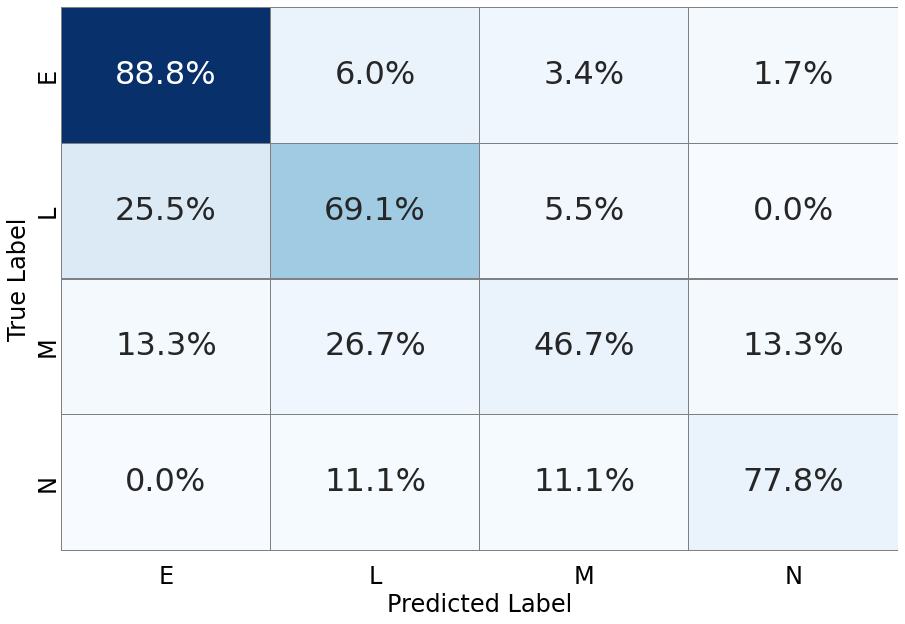










Number: 1

Train data: (780, 14) , Train labels: (780,)
Test data: (195, 14) , Test labels: (195,)

Name: KNeighborsClassifier()

Algorithm Name: KNeighbors

Params: [{'n_neighbors': [5, 10, 20], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2], 'metric': ['minkowski', 'euclidean', 'manhattan']}]

Grid Search tuning for accuracy
				

 ========================= MODEL ========================= 
Fitting 10 folds for each of 108 candidates, totalling 1080 fits

 ======= Best parameters ======= 
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

 ======= Best Estimator ======= 


 =============== Overall Average Results =============== 

Accuracy =  0.8153846153846154
Sensitivity =  0.8153846153846154
Precision =  0.840880647130647
F1 =  0.7997817449276335


 =============== Classwise Results =============== 

Accuracy =  [0.98275862 0.56363636 0.4        0.88888889]
Sensitivity =  [0.

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

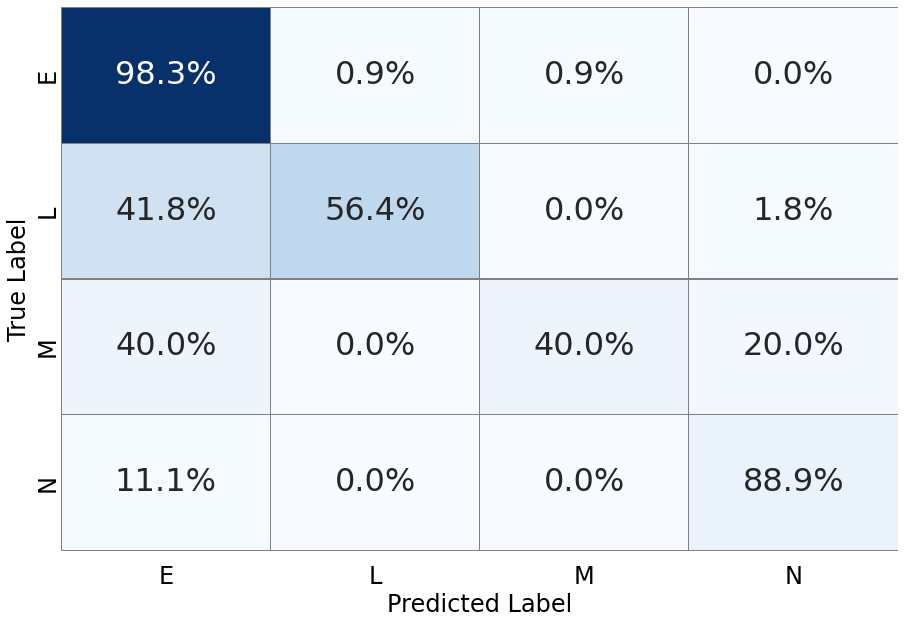










Number: 2

Train data: (780, 14) , Train labels: (780,)
Test data: (195, 14) , Test labels: (195,)

Name: BaggingClassifier()

Algorithm Name: BaggingClassifier

Params: [{'n_estimators': [10, 25, 50], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0], 'random_state': [None]}]

Grid Search tuning for accuracy
				

 ========================= MODEL ========================= 
Fitting 10 folds for each of 12 candidates, totalling 120 fits

 ======= Best parameters ======= 
{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 25, 'random_state': None}

 ======= Best Estimator ======= 


 =============== Overall Average Results =============== 

Accuracy =  0.8051282051282052
Sensitivity =  0.8051282051282052
Precision =  0.799002624671916
F1 =  0.7979695201917424


 =============== Classwise Results =============== 

Accuracy =  [0.90517241 0.70909091 0.4        0.77777778]
Sensitivity =  [0.90517241 0.70909091 0.4        0.77777778]
Precision =  [0.82677165 0.78       0.

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

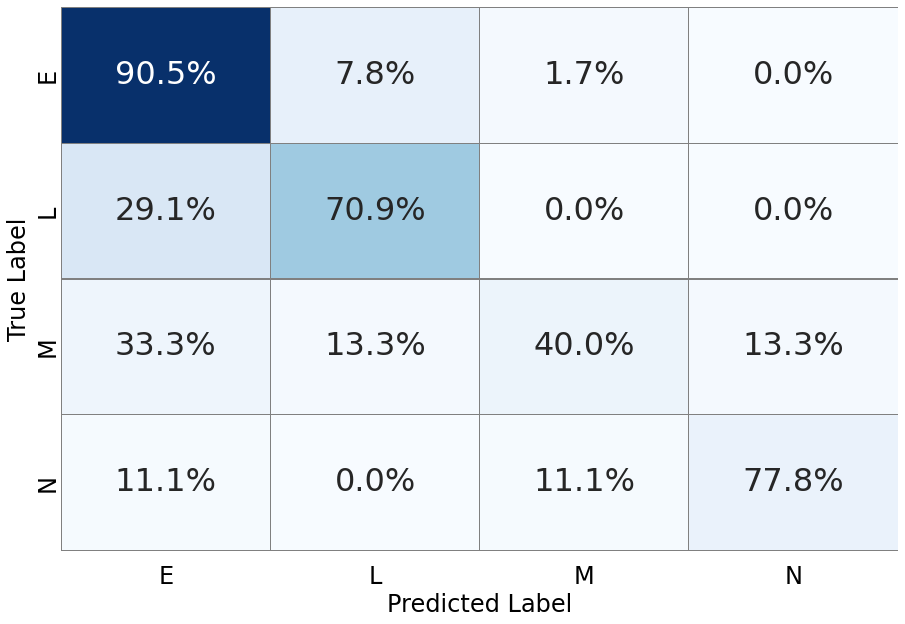










Number: 3

Train data: (780, 14) , Train labels: (780,)
Test data: (195, 14) , Test labels: (195,)

Name: GradientBoostingClassifier()

Algorithm Name: GradientBoosting

Params: [{'loss': ['deviance', 'exponential'], 'n_estimators': [10, 25, 50], 'max_features': ['log2', 'sqrt'], 'max_depth': [3, 10, 20]}]

Grid Search tuning for accuracy
				

 ========================= MODEL ========================= 
Fitting 10 folds for each of 36 candidates, totalling 360 fits

 ======= Best parameters ======= 
{'loss': 'deviance', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}

 ======= Best Estimator ======= 


 =============== Overall Average Results =============== 

Accuracy =  0.8153846153846154
Sensitivity =  0.8153846153846154
Precision =  0.8105070237261068
F1 =  0.8061465470123383


 =============== Classwise Results =============== 

Accuracy =  [0.9137931  0.74545455 0.33333333 0.77777778]
Sensitivity =  [0.9137931  0.74545455 0.33333333 0.77777778]
Precision =  

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

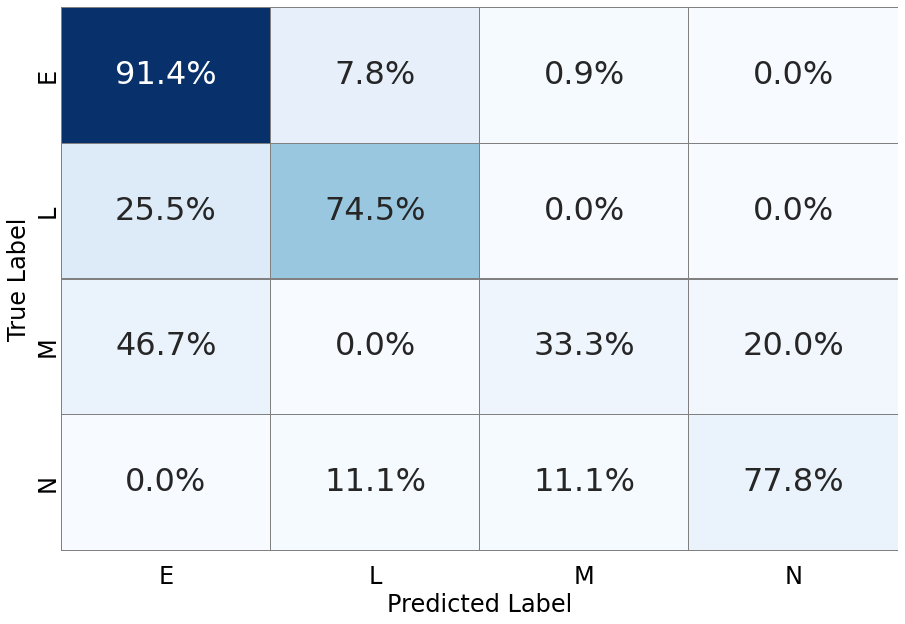

In [22]:
Path_S = os.path.join(os.getcwd() + '\January/Weights')
print(Path_S)

Path_S_1 = os.path.join(os.getcwd() + '\January/Metrics/')
print(Path_S_1)

create_directory(Path_S)
create_directory(Path_S_1)
    
Mode = 0
num_classes = 4

print('\n\n =============== Data Dimensions =============== ')
X_train, Y_train = Nuceli_Output_Type, Nuceli_Label_Type
print('\nNuceli Features: ',X_train.shape)
print('Nuceli  Labels: ',Y_train.shape)

indices = np.arange(X_train.shape[0])
size1 = 0.80    #Split Data

X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(X_train, Y_train, indices, train_size=size1, random_state=106, shuffle=True)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('\nTrain Radiomics data:', X_train.shape,', Train Radiomics labels:', Y_train.shape)
print('Test Radiomics data:', X_test.shape,', Test Radiomics labels:', Y_test.shape)

Nuceli_Output_train, Nuceli_Label_train = Nuceli_Output_Type_I[indices_train], Nuceli_Label_Type_I[indices_train]
Nuceli_Output_test, Nuceli_Label_test = Nuceli_Output_Type_I[indices_test], Nuceli_Label_Type_I[indices_test]

print('\nTrain Image data:', Nuceli_Output_train.shape,', Train Mask labels:', Nuceli_Label_train.shape)
print('Test Image data:', Nuceli_Output_test.shape,', Test Mask labels:', Nuceli_Label_test.shape)

tuned_parameters = [[{'max_depth' : [10, 50, 100, 500], 'min_samples_split' : [2, 10, 50], 'min_samples_leaf': [1, 5, 10], 'max_features' : ['sqrt', 'log2']}],
                    [{'n_neighbors' : [5, 10, 20],'weights': ['uniform', 'distance'], 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],'p' : [1, 2],'metric': ['minkowski', 'euclidean', 'manhattan']}],
                    [{'n_estimators':[10, 25, 50],'max_samples':[0.5, 1.0],'max_features':[0.5, 1.0],'random_state':[None]}],
                    [{'loss': ['deviance', 'exponential'],'n_estimators' : [10, 25, 50],'max_features' : ['log2', 'sqrt'],'max_depth' : [3, 10, 20] }],
                    ]

algorithms = [DecisionTreeClassifier(), KNeighborsClassifier(), BaggingClassifier(), GradientBoostingClassifier()]
algorithm_names = ["DecisionTree", "KNeighbors", "BaggingClassifier", "GradientBoosting"]
scores_save = []

print("\n\n =============== Traditional Classifier ===============")
for ib in range(0, 4):
    print('\n\n\n\n\n\n\n\n')
    print('Number:', ib)
    print('\nTrain data:', X_train.shape,', Train labels:', Y_train.shape)
    print('Test data:', X_test.shape,', Test labels:', Y_test.shape)

    kfold_splits = 10
    scores = ['accuracy']

    for score in scores:
        
        if option_Org==1:
            filepath = Path_S + "/Best_Classifier_E_Breast_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
            filepath_CM = Path_S + "/Best_Classifier_E_Breast_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

        elif option_Org==2:
            filepath = Path_S + "/Best_Classifier_E_Kidney_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
            filepath_CM = Path_S + "/Best_Classifier_E_Kidney_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

        elif option_Org==3:
            filepath = Path_S + "/Best_Classifier_E_Lung_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
            filepath_CM = Path_S + "/Best_Classifier_E_Lung_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

        elif option_Org==4:
            filepath = Path_S + "/Best_Classifier_E_Prostate_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
            filepath_CM = Path_S + "/Best_Classifier_E_Prostate_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

        elif option_Org==5:
            filepath = Path_S + "/Best_Classifier_E_All_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
            filepath_CM = Path_S + "/Best_Classifier_E_All_" + str(algorithm_names[ib]) + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"
        
        if not (os.path.exists(filepath)):
            print("\nName: %s" %algorithms[ib])
            print("\nAlgorithm Name: %s" %algorithm_names[ib])
            print("\nParams: %s" %tuned_parameters[ib])
            print("\nGrid Search tuning for %s" % score)
            
            clf_ = GridSearchCV(algorithms[ib], tuned_parameters[ib], cv=kfold_splits, scoring='%s' % score, verbose=3, n_jobs=-1)

            if Mode==0:
                
                print('\t\t\t\t\n\n ========================= MODEL ========================= ')
                with tf.device('/device:CPU:0'):
                    clf_.fit(X_train, Y_train)
            elif Mode==1:
                with tf.device('/device:GPU:0'):
                    clf_.fit(X_train, Y_train)

            print("\n ======= Best parameters ======= ")
            print(clf_.best_params_)
            parameters = clf_.best_params_

#             For hyper parameter tuning
            print("\n ======= Best Estimator ======= ")
            clf_ = clf_.best_estimator_

            # save the model to disk
            joblib.dump(clf_, filepath)
            
        else:
            print("\nName: %s" %algorithms[ib])
            print("\nAlgorithm Name: %s" %algorithm_names[ib])
            # load the model from disk
            clf_ = joblib.load(filepath)
    
        print('\n\n =============== Overall Average Results =============== ')
        print('\nAccuracy = ', clf_.score(X_test, Y_test))
        
        scores_save.append(clf_.score(X_test, Y_test))

        test_labels, predicted_classes = Y_test, clf_.predict(X_test)

        print("Sensitivity = ", recall_score(test_labels, predicted_classes, average='weighted'))
        print("Precision = ", precision_score(test_labels, predicted_classes, average='weighted'))
        print("F1 = ", f1_score(test_labels, predicted_classes, average='weighted'))


        print('\n\n =============== Classwise Results =============== ')
        cmat = confusion_matrix(test_labels, predicted_classes) 
        print("\nAccuracy = ", cmat.diagonal()/cmat.sum(axis=1))
        print("Sensitivity = ", recall_score(test_labels, predicted_classes, average=None))
        print("Precision = ", precision_score(test_labels, predicted_classes, average=None))
        print("F1 = ", f1_score(test_labels, predicted_classes, average=None))

        print("\n\n")            
        target_names = ["Class {}".format(ia) for ia in range(num_classes)]
        print(classification_report(test_labels, predicted_classes, target_names=target_names))

        if option_Org==1:
            Final_P = Path_S_1 + "/Metrics_Result_E_Breast_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
            Final_P_1 = Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Breast_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

        elif option_Org==2:
            Final_P = Path_S_1 + "/Metrics_Result_E_Kidney_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
            Final_P_1 = Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Kidney_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

        elif option_Org==3:
            Final_P = Path_S_1 + "/Metrics_Result_E_Lung_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
            Final_P_1 = Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Lung_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

        elif option_Org==4:
            Final_P = Path_S_1 + "/Metrics_Result_E_Prostate_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
            Final_P_1 = Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Prostate_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

        elif option_Org==5:
            Final_P = Path_S_1 + "/Metrics_Result_E_All_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
            Final_P_1 = Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_All_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
        
        with open(Final_P, "a") as myfile:
            myfile.write("\n\n ============================ Dataset ================================ ")
            myfile.write("\n Nuceli Configuration: Nuclei Type = " + str(Name_T) + ", SamplesNo = " + str(samples_Select) + "\n")                    
            myfile.write("\n Classifier = " + str(algorithms[ib])+ "\n")
            if option_Mode==2:
                myfile.write("\nBest Parameters = " + str(parameters) + "\n")

            myfile.write("\n =============== Overall Average Results =============== ")
            myfile.write("\nAccuracy: " + str("%.5f" % clf_.score(X_test, Y_test)))
            myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average='weighted')))
            myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average='weighted')))
            myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average='weighted')) + "\n")

            myfile.write("\n =============== Classwise Average Results =============== ")
            myfile.write("\nAccuracy: " + str(cmat.diagonal()/cmat.sum(axis=1)))
            myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average=None)))
            myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average=None)))
            myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average=None)) + "\n")

            
        with open(Final_P_1, "a") as myfile:
            myfile.write("Nuceli Configuration: Nuclei Type = " + str(Name_T) + ", SamplesNo = " + str(samples_Select) + "\n")                    
            myfile.write("Classifier = " + str(algorithms[ib])+ "\n")
            if option_Mode==1:
                myfile.write("Best Parameters = " + str(parameters) + "\n")
                myfile.write("\n")

        columns = 16
        work_directory_P = os.getcwd() + "\January/ResultsPredicted"

        if not os.path.exists(work_directory_P):
            os.mkdir(work_directory_P)

        fig=plt.figure(figsize=(8, 8))

        left  = 0.125  # the left side of the subplots of the figure
        right = 1    # the right side of the subplots of the figure
        bottom = 0.1   # the bottom of the subplots of the figure
        top = 0.9      # the top of the subplots of the figure
        wspace = 0.25   # the amount of width reserved for blank space between subplots
        hspace = 0.25   # the amount of height reserved for white space between subplots

        plt.subplots_adjust( left, bottom, right, top, wspace, hspace)
        columns = 4
        rows = 4
        f = 12
        print('\n\n =============== Correct Predicted Samples =============== ')
        correct = np.where(predicted_classes==test_labels)[0]
        print("\nFound %d correct labels" % len(correct))

        fig=plt.figure(figsize=(8, 8))
        plt.subplots_adjust( left, bottom, right, top, wspace, hspace)

        print('\n\n =============== Incorrect Predicted Samples =============== ')

        incorrect = np.where(predicted_classes!=test_labels)[0]
        print("\nFound %d incorrect labels" % len(incorrect))

        print('\n\n =============== Save Correct Predicted Samples =============== ')
        if option_Org==1:
            work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Breast_' + str(Name_T) + "_" + str(samples_Select))

        elif option_Org==2:
            work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Kidney_' + str(Name_T) + "_" + str(samples_Select))

        elif option_Org==3:
            work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Lung_' + str(Name_T) + "_" + str(samples_Select))

        elif option_Org==4:
            work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Prostate_' + str(Name_T) + "_" + str(samples_Select))

        elif option_Org==5:
            work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_All_' + str(Name_T) + "_" + str(samples_Select))

        if not os.path.exists(work_directory_NT):
            os.mkdir(work_directory_NT)
        print(work_directory_NT)

        work_directory_NT = os.path.join(work_directory_NT + '/' + str(algorithm_names[ib]))
        if not os.path.exists(work_directory_NT):
            os.mkdir(work_directory_NT)
        print(work_directory_NT)


        Name_Nuclei, Name_Nuclei_Mask = "", "" 
        correct_Final = np.where(predicted_classes==test_labels)[0]
        print("\nSave %d correct labels" % len(correct_Final))
        for i1, correct_S in enumerate(correct_Final[:len(correct_Final)]):
            if test_labels[correct_S]==0 and predicted_classes[correct_S]==0:
                Temp_Save = '/Type_E-'
            elif test_labels[correct_S]==1 and predicted_classes[correct_S]==1:
                Temp_Save = '/Type_L-'
            elif test_labels[correct_S]==2 and predicted_classes[correct_S]==2:
                Temp_Save = '/Type_M-'
            elif test_labels[correct_S]==3 and predicted_classes[correct_S]==3:
                Temp_Save = '/Type_N-'
                
            Name_Nuclei, Name_Nuclei_Mask = Save_Type_Directory(test_labels[correct_S])
            work_directory_NT_Image = os.path.join(work_directory_NT + '/' + Name_Nuclei)
            if not os.path.exists(work_directory_NT_Image):
                os.mkdir(work_directory_NT_Image)

            work_directory_NT_Mask = os.path.join(work_directory_NT + '/' + Name_Nuclei_Mask)
            if not os.path.exists(work_directory_NT_Mask):
                os.mkdir(work_directory_NT_Mask)

            from PIL import Image
            im = Image.fromarray(Nuceli_Output_test[correct_S,:,:,:].astype('uint8'))
            im.save(work_directory_NT_Image + Temp_Save + '_' + str(i1) + '.jpg')
            
            im = Image.fromarray(Nuceli_Label_test[correct_S,:,:].astype('uint8'))
            im.save(work_directory_NT_Mask + Temp_Save + '_' + str(i1) + '.jpg')

        print("\nDone \nDone \nDone")

        work_directory_C = os.getcwd() + "\January/Results_CM"
        if not os.path.exists(work_directory_C):
            os.mkdir(work_directory_C)

        if option_Org==1:
            option_D0a = 'Classify_E_Breast_' + str(Name_T) + "_" + str(samples_Select) + "_" + str(algorithm_names[ib])

        elif option_Org==2:
            option_D0a = 'Classify_E_Kidney_' + str(Name_T) + "_" + str(samples_Select) + "_" + str(algorithm_names[ib])

        elif option_Org==3:
            option_D0a = 'Classify_E_Lung_' + str(Name_T) + "_" + str(samples_Select) + "_" + str(algorithm_names[ib])

        elif option_Org==4:
            option_D0a = 'Classify_E_Prostate_' + str(Name_T) + "_" + str(samples_Select) + "_" + str(algorithm_names[ib])

        elif option_Org==5:
            option_D0a = 'Classify_E_All_' + str(Name_T) + "_" + str(samples_Select) + "_" + str(algorithm_names[ib])

            
        normalize = False
        plot_cm(test_labels, predicted_classes, normalize, work_directory_C, option_D0a)
        del clf_
    
score, algorithm_Select, algorithm_name_Select  = bubbleSort(scores_save, algorithms, algorithm_names)
# print(score, algorithm, algorithm_name)
    
del predicted_classes, test_labels, target_names

In [23]:
print("\n Done Training Classifiers")


 Done 
 Done 
 Done


In [24]:
print("\nOption Select:", option_RT, "\nRadiomic Features", Name_T, "\nNo. of Samples:", samples_Select)
print("\nScore: ", score, "\nAlgorithm Name: ", algorithm_name_Select, "\nAlgorithm: ", algorithm_Select)


Option Select: 3 
Radiomic Features 3-GLRLM 
No. of Samples: 14

Score:  0.8153846153846154 
Algorithm Name:  KNeighbors 
Algorithm:  KNeighborsClassifier()


In [25]:
Path_S_1 = os.path.join(os.getcwd() + '\January/Metrics')
print(Path_S_1)


if option_Org==1:
    file1 = open(Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Breast_" + str(Name_T) + "_" + str(samples_Select) + ".txt", "r")

elif option_Org==2:
    file1 = open(Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Kidney_" + str(Name_T) + "_" + str(samples_Select) + ".txt", "r")

elif option_Org==3:
    file1 = open(Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Lung_" + str(Name_T) + "_" + str(samples_Select) + ".txt", "r")

elif option_Org==4:
    file1 = open(Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_Prostate_" + str(Name_T) + "_" + str(samples_Select) + ".txt", "r")

elif option_Org==5:
    file1 = open(Path_S_1 + "/Metrics_Classifier_Parameters_Result_E_All_" + str(Name_T) + "_" + str(samples_Select) + ".txt", "r")


count = 0

text_1 = ['Classifier = ', '()']
text_2 = ['Nuceli Configuration']
text_3 = ['Best Parameters =']
text_Classifier = ['Classifier = DecisionTree()' ,'Classifier = KNeighbors()' ,'Classifier = BaggingClassifier()', 'Classifier = GradientBoosting()']


# Using for loop
for line in file1:
    count += 1
    Join_Name_Classifier = text_1[0], algorithm_name_Select, text_1[1]
    Temp  = "".join(Join_Name_Classifier)

    if Temp == line.strip():
        print(Temp)
        
    if count==1 and Temp==text_Classifier[0] or count==3 and Temp==text_Classifier[0]:
        print("{}".format(line.strip()))
        if count==3:
            B = line.strip().split()

    elif count==5 and Temp==text_Classifier[1] or count==7 and Temp==text_Classifier[1]:
        print("{}".format(line.strip()))
        if count==7:
            B = line.strip().split()

    elif count==9 and Temp==text_Classifier[2] or count==11 and Temp==text_Classifier[2]:
        print("{}".format(line.strip()))
        if count==11:
            B = line.strip().split()
            
    elif count==13 and Temp==text_Classifier[3] or count==15 and Temp==text_Classifier[3]:
        print("{}".format(line.strip()))
        if count==15:
            B = line.strip().split()

# Closing files
file1.close()

import re

Parameters_Name = []
Parameters_Value = []

for F in range(3, len(B)):
    if (F % 2) != 0:
        result_Parameters = re.sub(r'\}|\{|\'|\:|\'', '', str(B[F]))
        result_Parameters = result_Parameters.replace('"','')
        Parameters_Name.append(result_Parameters)
    else:
        result_Parameters = re.sub(r'\}|\{', '', str(B[F]))
        result_Parameters = re.sub("\'",'', result_Parameters)
        result_Parameters = re.sub(r'\s*[{}<>\[\],;\'"]\s*', '', result_Parameters)
        Parameters_Value.append(result_Parameters)

print("\n \nParameters Name: ", Parameters_Name)
print("Parameters Value: ", Parameters_Value)


D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22\January/Metrics
Nuceli Configuration: Nuclei Type = 3-GLRLM, SamplesNo = 14
Best Parameters = {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

 
Parameters Name:  ['algorithm', 'metric', 'n_neighbors', 'p', 'weights']
Parameters Value:  ['ball_tree', 'minkowski', '20', '1', 'distance']


In [26]:
if  Temp==text_Classifier[0]:
    tuned_parameters_Select = [{'max_depth':[Parameters_Value[0]], 
                                'max_features':[Parameters_Value[1]], 
                                'min_samples_split':[Parameters_Value[2]], 
                                'min_samples_leaf':[Parameters_Value[3]], }]

elif Temp==text_Classifier[1]:
    tuned_parameters_Select = [{'algorithm':[Parameters_Value[0]],
                                'metric':[Parameters_Value[1]],
                                'n_neighbors':[Parameters_Value[2]],
                                'p':[Parameters_Value[3]],
                                'weights':[Parameters_Value[4]], }]

elif Temp==text_Classifier[2]:
    tuned_parameters_Select = [{'max_features':[Parameters_Value[0]],
                                'max_samples':[Parameters_Value[1]],
                                'n_estimators':[Parameters_Value[2]],
                                'random_state':[Parameters_Value[3]], }]

elif Temp==text_Classifier[3]:
    tuned_parameters_Select = [{'loss':[Parameters_Value[0]], 
                                'max_depth':[Parameters_Value[1]], 
                                'max_features':[Parameters_Value[2]], 
                                'n_estimators':[Parameters_Value[3]], }]

# algorithm_name_Select
algorithms = algorithm_Select
algorithm_names = f'"{algorithm_name_Select}"'

print("\nOption Select:", option_RT, "\nRadiomic Features:", Name_T, "\nNo. of Samples:", samples_Select)
print("\nScore: ", score, "\nAlgorithm: ", algorithms, "\nAlgorithm Name: ", algorithm_names, "\nParameters: %s" %tuned_parameters_Select)



Option Select: 3 
Radiomic Features: 3-GLRLM 
No. of Samples: 14

Score:  0.8153846153846154 
Algorithm:  KNeighborsClassifier() 
Algorithm Name:  "KNeighbors" 
Parameters: [{'algorithm': ['ball_tree'], 'metric': ['minkowski'], 'n_neighbors': ['20'], 'p': ['1'], 'weights': ['distance']}]


D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22\January/Weights_Final
D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code 19-05-2022 Professor Idea\Final Code\Decemeber_22\January/Metrics_Final


 =============== Data Dimensions =============== 

Nuceli Features:  (975, 14)
Nuceli  Labels:  (975,)

Train Radiomics data: (780, 14) , Train Radiomics labels: (780,)
Test Radiomics data: (195, 14) , Test Radiomics labels: (195,)

Train Image data: (780, 128, 128, 3) , Train Mask labels: (780, 128, 128)
Test Image data: (195, 128, 128, 3) , Test Mask labels: (195, 128, 128)


 =============== Traditional Classifier ===============

Train data: (780, 14) , Train labels: (780,)
Test data: (195, 14) , Test labels: (195,)

Name: KNeighbors

Params: [{'algorithm': ['ball_tree'], 'metric': ['minkowski'], 'n_neighbors': ['20'], 'p': ['1'], 'weights': ['distance']}]

File Path: D:\Research Work\Paper - 4\BreastLiverNet\MoNuSAC\My_Code

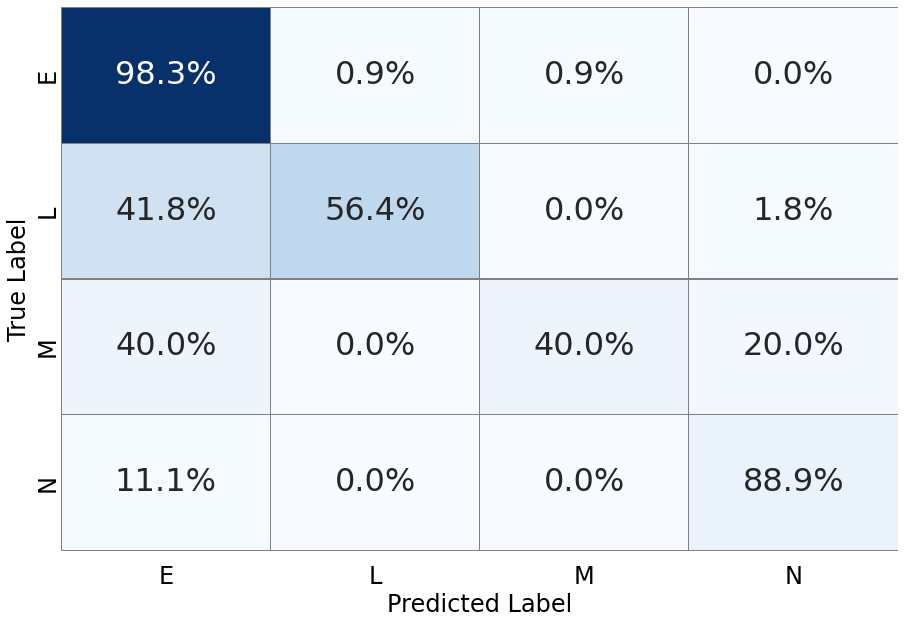


Done 
Done 
Done


In [27]:
Path_S = os.path.join(os.getcwd() + '\January/Weights_Final')
print(Path_S)

Path_S_1 = os.path.join(os.getcwd() + '\January/Metrics_Final')
print(Path_S_1)

create_directory(Path_S)
create_directory(Path_S_1)

work_directory_P = os.path.join(os.getcwd() + '\January/ResultsPredicted_Final')
work_directory_C = os.path.join(os.getcwd() + '\January/Results_CM_Final')

Mode = 0
num_classes = 4

print('\n\n =============== Data Dimensions =============== ')

X_train, Y_train = Nuceli_Output_Type, Nuceli_Label_Type
print('\nNuceli Features: ',X_train.shape)
print('Nuceli  Labels: ',Y_train.shape)

indices = np.arange(X_train.shape[0])
size1 = 0.80    #Data Split

X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(X_train, Y_train, indices, train_size=size1, random_state=106, shuffle=True)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('\nTrain Radiomics data:', X_train.shape,', Train Radiomics labels:', Y_train.shape)
print('Test Radiomics data:', X_test.shape,', Test Radiomics labels:', Y_test.shape)

Nuceli_Output_train, Nuceli_Label_train = Nuceli_Output_Type_I[indices_train], Nuceli_Label_Type_I[indices_train]
Nuceli_Output_test, Nuceli_Label_test = Nuceli_Output_Type_I[indices_test], Nuceli_Label_Type_I[indices_test]

print('\nTrain Image data:', Nuceli_Output_train.shape,', Train Mask labels:', Nuceli_Label_train.shape)
print('Test Image data:', Nuceli_Output_test.shape,', Test Mask labels:', Nuceli_Label_test.shape)

print("\n\n =============== Traditional Classifier ===============")

print('\nTrain data:', X_train.shape,', Train labels:', Y_train.shape)
print('Test data:', X_test.shape,', Test labels:', Y_test.shape)

kfold_splits = 10
score = ['accuracy']

if option_Org==1:
    filepath_F = Path_S + "/Best_E_Breast_" + algorithm_name_Select + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
    filepath_CM_F = Path_S + "/Best_E_Breast_" + algorithm_name_Select + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"
    
elif option_Org==2:
    filepath_F = Path_S + "/Best_E_Kidney_" + algorithm_name_Select + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
    filepath_CM_F = Path_S + "/Best_E_Kidney_" + algorithm_name_Select + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

elif option_Org==3:
    filepath_F = Path_S + "/Best_E_Lung_" + algorithm_name_Select + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
    filepath_CM_F = Path_S + "/Best_Lung_" + algorithm_name_Select + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

elif option_Org==4:
    filepath_F = Path_S + "/Best_E_Prostate_" + algorithm_name_Select + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
    filepath_CM_F = Path_S + "/Best_E_Prostate_" + algorithm_name_Select + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"

elif option_Org==5:
    filepath_F = Path_S + "/Best_E_All_" + algorithm_name_Select + "_Type_" + str(Name_T) +  "_Samples_No_" + str(samples_Select) + ".joblib"
    filepath_CM_F = Path_S + "/Best_E_All_" + algorithm_name_Select + "_Type_" + str(Name_T) + "_Samples_No_" + str(samples_Select) + ".jpg"



if Temp==text_Classifier[0]:
    algorithm_F = DecisionTreeClassifier(
    max_depth = Parameters_Value[0], 
    max_features = str(Parameters_Value[1]), 
    min_samples_split = float(Parameters_Value[2]), 
    min_samples_leaf = float(Parameters_Value[3]))
    
elif Temp==text_Classifier[1]:
    algorithm_F = KNeighborsClassifier(
    algorithm = Parameters_Value[0], 
    metric = Parameters_Value[1], 
    n_neighbors = int(Parameters_Value[2]), 
    p = float(Parameters_Value[3]), 
    weights = Parameters_Value[4])
    
elif Temp==text_Classifier[2]:
    algorithm_F = BaggingClassifier(
    max_features = float(Parameters_Value[0]), 
    max_samples = float(Parameters_Value[1]), 
    n_estimators = int(Parameters_Value[2]), 
    random_state = None)
        
elif Temp==text_Classifier[3]:
    algorithm_F = GradientBoostingClassifier(
    loss = Parameters_Value[0], 
    max_depth = float(Parameters_Value[1]), 
    max_features = float(Parameters_Value[2]), 
    n_estimators = float(Parameters_Value[3]))

if not (os.path.exists(filepath_F)):
    print("\nName: %s" %algorithm_name_Select)
    print("\nParams: %s" %tuned_parameters_Select)
    print("\nFile Path: %s" %filepath_F)

    with tf.device('/device:GPU:0'):
        algorithm_F.fit(X_train, Y_train)

    # save the model to disk
    joblib.dump(algorithm_F, filepath_F)

else:
    print("\nName: %s" %algorithm_name_Select)
    print("\nFile Path: %s" %filepath_F)
    # load the model from disk
    algorithm_F = joblib.load(filepath_F)


print('\n\n =============== Overall Average Results =============== ')
print('\nAccuracy = ', algorithm_F.score(X_test, Y_test))

scores_save.append(algorithm_F.score(X_test, Y_test))

test_labels, predicted_classes = Y_test, algorithm_F.predict(X_test)

print("Sensitivity = ", recall_score(test_labels, predicted_classes, average='weighted'))
print("Precision = ", precision_score(test_labels, predicted_classes, average='weighted'))
print("F1 = ", f1_score(test_labels, predicted_classes, average='weighted'))


print('\n\n =============== Classwise Results =============== ')
cmat = confusion_matrix(test_labels, predicted_classes) 
print("\nAccuracy = ", cmat.diagonal()/cmat.sum(axis=1))
print("Sensitivity = ", recall_score(test_labels, predicted_classes, average=None))
print("Precision = ", precision_score(test_labels, predicted_classes, average=None))
print("F1 = ", f1_score(test_labels, predicted_classes, average=None))


print("\n\n")            
target_names = ["Class {}".format(ia) for ia in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))


if option_Org==1:
    Final_P = Path_S_1 + "/Metrics_Final_E_Breast_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
    Final_P_1 = Path_S_1 + "/Metrics_Parameters_Final_E_Breast_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

elif option_Org==2:
    Final_P = Path_S_1 + "/Metrics_Final_E_Kidney_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
    Final_P_1 = Path_S_1 + "/Metrics_Parameters_Final_E_Kidney_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

elif option_Org==3:
    Final_P = Path_S_1 + "/Metrics_Final_E_Lung_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
    Final_P_1 = Path_S_1 + "/Metrics_Parameters_Final_E_Lung_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

elif option_Org==4:
    Final_P = Path_S_1 + "/Metrics_Final_E_Prostate_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
    Final_P_1 = Path_S_1 + "/Metrics_Parameters_Final_E_Prostate_" + str(Name_T) + "_" + str(samples_Select) + ".txt"

elif option_Org==5:
    Final_P = Path_S_1 + "/Metrics_Final_E_All_" + str(Name_T) + "_" + str(samples_Select) + ".txt"
    Final_P_1 = Path_S_1 + "/Metrics_Parameters_Final_E_All_" + str(Name_T) + "_" + str(samples_Select) + ".txt"


with open(Final_P, "a") as myfile:
    myfile.write("\n\n ============================ Dataset ================================ ")
    myfile.write("\n Nuceli Configuration: Nuclei Type = " + str(Name_T) + ", SamplesNo = " + str(samples_Select) + "\n")                    
    myfile.write("\n Classifier = " + algorithm_name_Select + "\n")
    if option_Mode==1:
        myfile.write("\nBest Parameters = " + str(tuned_parameters_Select) + "\n")

    myfile.write("\n =============== Overall Average Results =============== ")
    myfile.write("\nAccuracy: " + str("%.5f" % algorithm_F.score(X_test, Y_test)))
    myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average='weighted')))
    myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average='weighted')))
    myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average='weighted')) + "\n")

    myfile.write("\n =============== Classwise Average Results =============== ")
    myfile.write("\nAccuracy: " + str(cmat.diagonal()/cmat.sum(axis=1)))
    myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average=None)))
    myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average=None)))
    myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average=None)) + "\n")


with open(Final_P_1, "a") as myfile:
    myfile.write("\n")
    myfile.write("Nuceli Configuration: Nuclei Type = " + str(Name_T) + ", SamplesNo = " + str(samples_Select) + "\n")                    
    myfile.write("Classifier = " + algorithm_name_Select + "\n")
    myfile.write("Best Parameters = " + str(tuned_parameters_Select) + "\n")
    myfile.write("\n")


if not os.path.exists(work_directory_P):
    os.mkdir(work_directory_P)


print('\n\n =============== Save Correct Predicted Samples =============== ')

if option_Org==1:
    work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Breast_' + str(Name_T) + "_" + str(samples_Select))

elif option_Org==2:
    work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Kidney_' + str(Name_T) + "_" + str(samples_Select))

elif option_Org==3:
    work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Lung_' + str(Name_T) + "_" + str(samples_Select))

elif option_Org==4:
    work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_Prostate_' + str(Name_T) + "_" + str(samples_Select))

elif option_Org==5:
    work_directory_NT = os.path.join(work_directory_P + '/' + 'Classify_E_All_' + str(Name_T) + "_" + str(samples_Select))


if not os.path.exists(work_directory_NT):
    os.mkdir(work_directory_NT)

work_directory_NT = os.path.join(work_directory_NT + '/' + algorithm_name_Select)
if not os.path.exists(work_directory_NT):
    os.mkdir(work_directory_NT)

Name_Nuclei, Name_Nuclei_Mask = "", "" 
correct_Final = np.where(predicted_classes==test_labels)[0]
print("\nDirectory:", work_directory_NT)
print("\nSave %d Correct Labels" % len(correct_Final))
for i1, correct_S in enumerate(correct_Final[:len(correct_Final)]):
    if test_labels[correct_S]==0 and predicted_classes[correct_S]==0:
        Temp_Save = '/Type_E-'
    elif test_labels[correct_S]==1 and predicted_classes[correct_S]==1:
        Temp_Save = '/Type_L-'
    elif test_labels[correct_S]==2 and predicted_classes[correct_S]==2:
        Temp_Save = '/Type_M-'
    elif test_labels[correct_S]==3 and predicted_classes[correct_S]==3:
        Temp_Save = '/Type_N-'

    Name_Nuclei, Name_Nuclei_Mask = Save_Type_Directory(test_labels[correct_S])
    work_directory_NT_Image = os.path.join(work_directory_NT + '/' + Name_Nuclei)
    if not os.path.exists(work_directory_NT_Image):
        os.mkdir(work_directory_NT_Image)

    work_directory_NT_Mask = os.path.join(work_directory_NT + '/' + Name_Nuclei_Mask)
    if not os.path.exists(work_directory_NT_Mask):
        os.mkdir(work_directory_NT_Mask)


    from PIL import Image
    im = Image.fromarray(Nuceli_Output_test[correct_S,:,:,:].astype('uint8'))
    im.save(work_directory_NT_Image + Temp_Save + '_' + str(i1) + '.jpg')

    im = Image.fromarray(Nuceli_Label_test[correct_S,:,:].astype('uint8'))
    im.save(work_directory_NT_Mask + Temp_Save + '_' + str(i1) + '.jpg')


if not os.path.exists(work_directory_C):
    os.mkdir(work_directory_C)

    
if option_Org==1:
    option_D0a = 'Classify_E_Breast_' + str(Name_T) + "_" + str(samples_Select) + "_" + algorithm_name_Select

elif option_Org==2:
    option_D0a = 'Classify_E_Kidney_' + str(Name_T) + "_" + str(samples_Select) + "_" + algorithm_name_Select

elif option_Org==3:
    option_D0a = 'Classify_E_Lung_' + str(Name_T) + "_" + str(samples_Select) + "_" + algorithm_name_Select

elif option_Org==4:
    option_D0a = 'Classify_E_Prostate_' + str(Name_T) + "_" + str(samples_Select) + "_" + algorithm_name_Select

elif option_Org==5:
    option_D0a = 'Classify_E_All_' + str(Name_T) + "_" + str(samples_Select) + "_" + algorithm_name_Select
 
    
normalize = False
plot_cm(test_labels, predicted_classes, normalize, work_directory_C, option_D0a)

del algorithm_F, predicted_classes, test_labels, target_names


In [28]:
print("\n Done Training Best Classifier")